
=== Linear Regression ===
R² Score: 0.660655188052065
MAE: 5271232.761129147
MSE: 56827459912039.555

=== Random Forest ===
R² Score: 0.5687684995609945
MAE: 5369190.722891566
MSE: 72215015350716.88

=== XGBoost ===
R² Score: 0.6356947728299899
MAE: 4869149.153866246
MSE: 61007388248878.15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61712
[LightGBM] [Info] Number of data points in the train set: 1660, number of used features: 606
[LightGBM] [Info] Start training from score 11092825.301205

=== LightGBM ===
R² Score: 0.654000570749329
MAE: 4648807.281142825
MSE: 57941857376466.44

=== CatBoost ===
R² Score: 0.6864081612864503
MAE: 4418314.152847013
MSE: 52514807994091.85

=== ElasticNet ===
R² Score: 0.6534472282456814
MAE: 5256807.867048981
MSE: 58034521380265.8

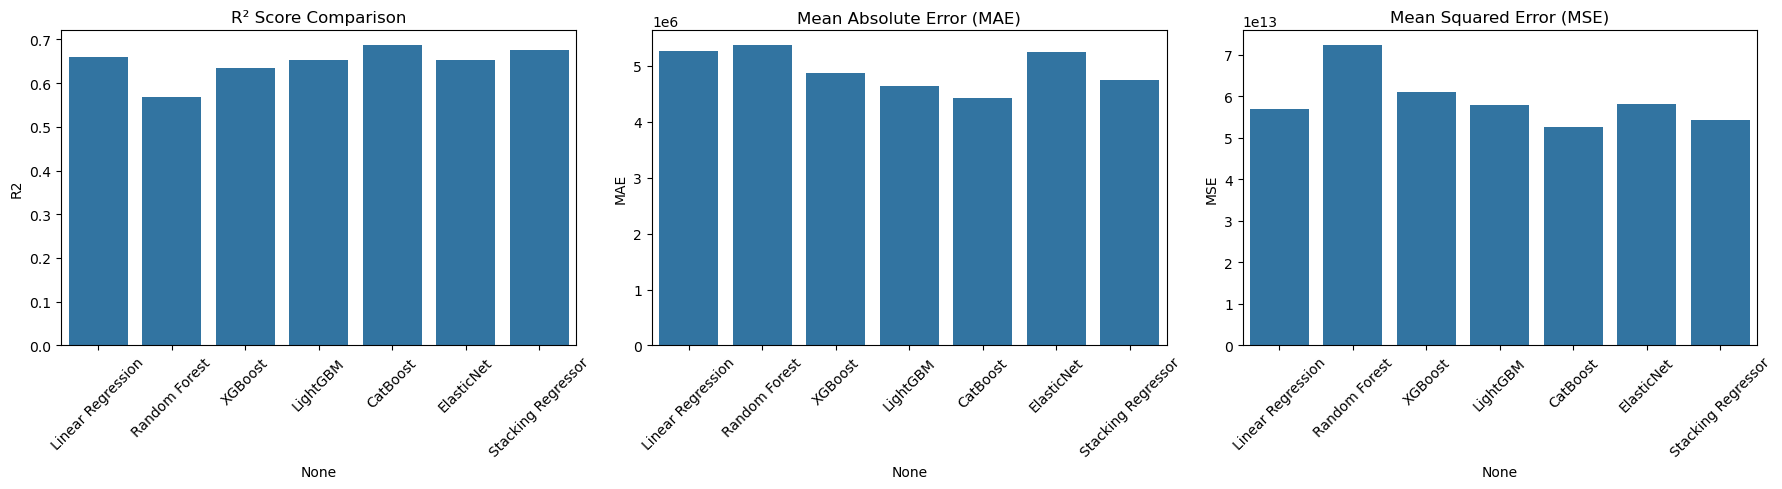

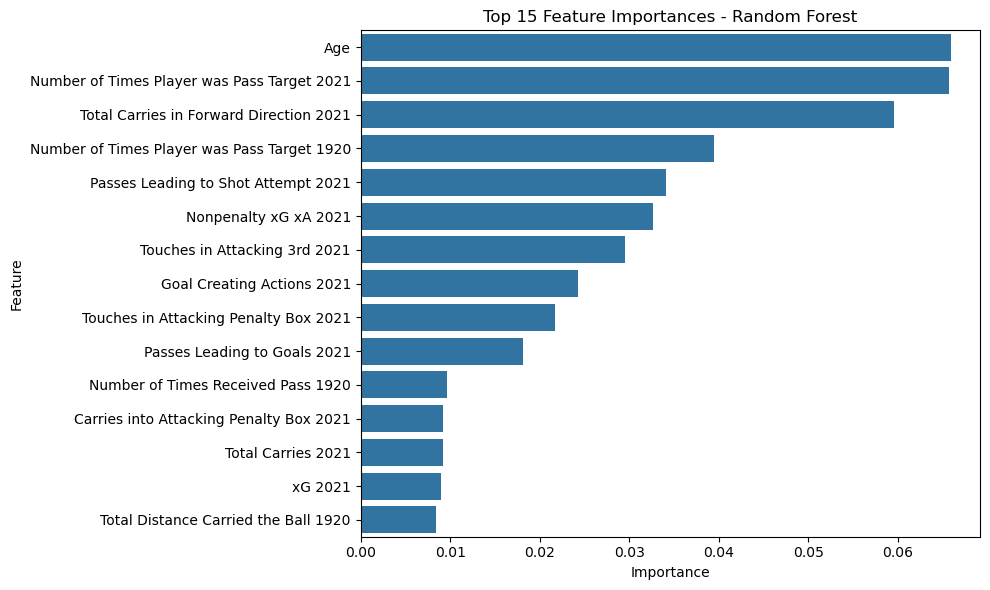

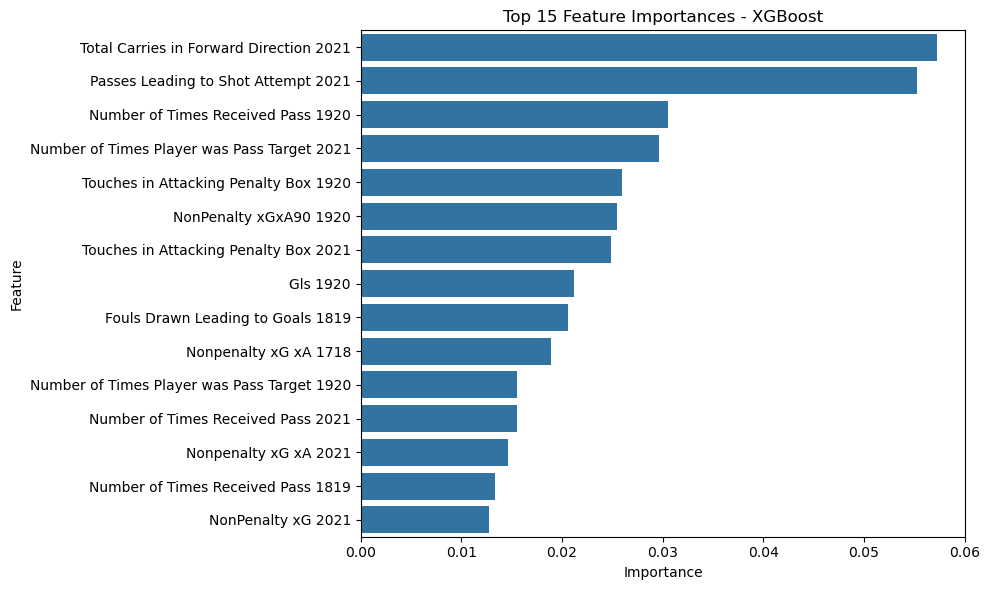

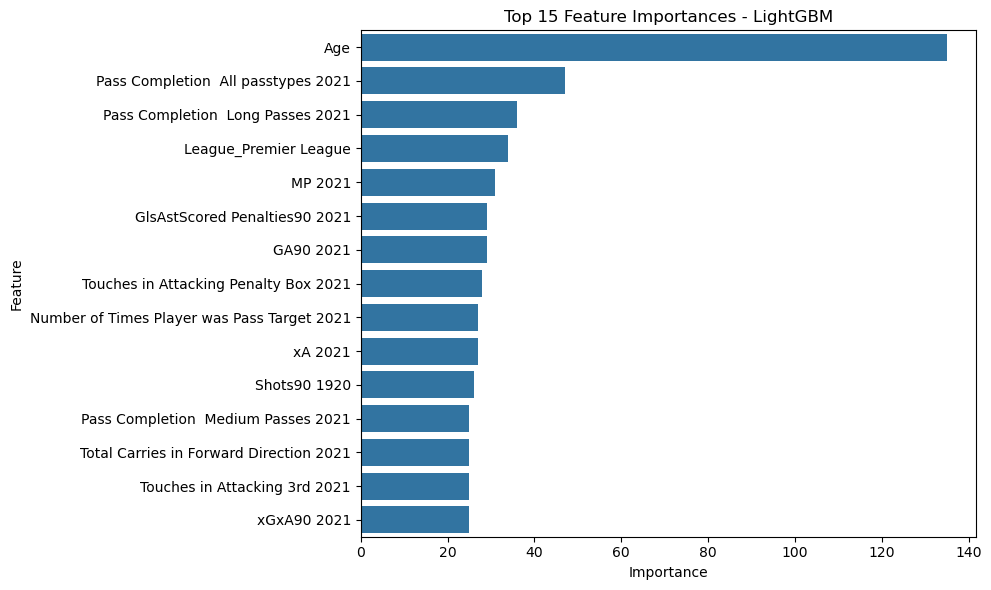

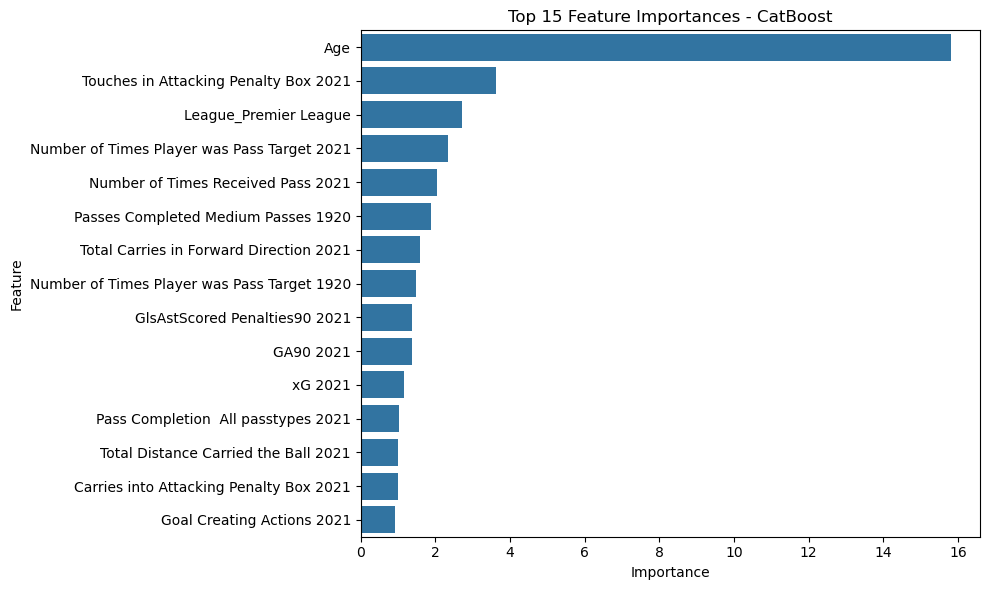

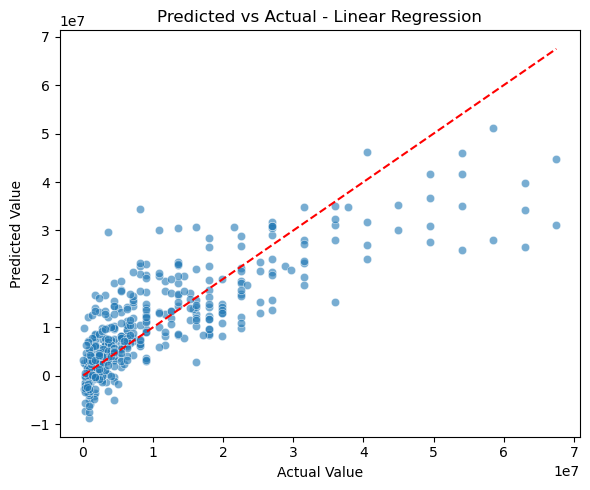

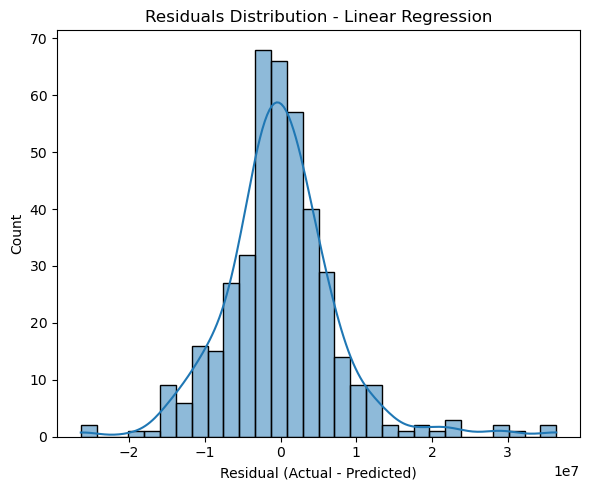

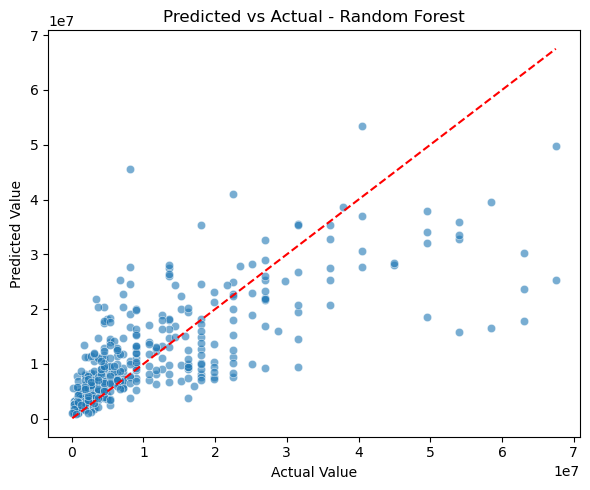

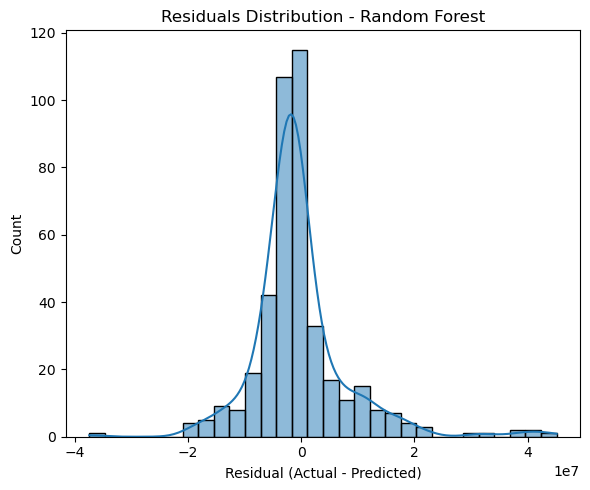

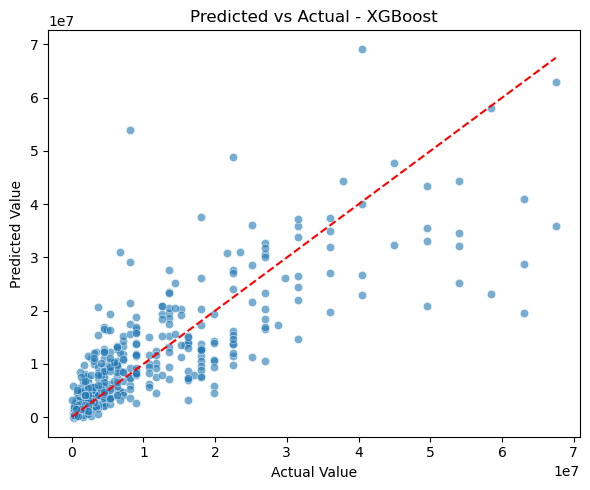

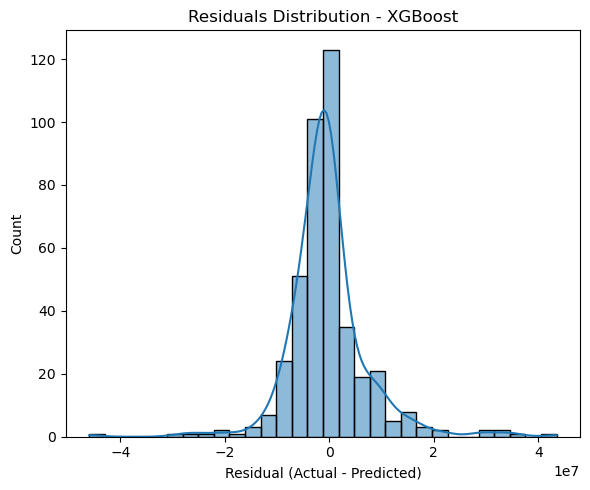

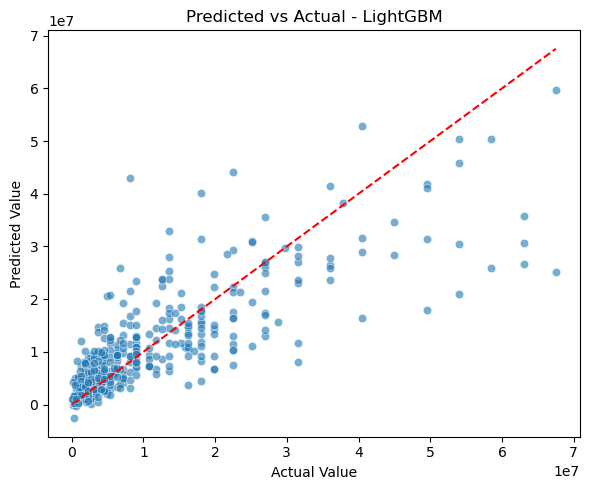

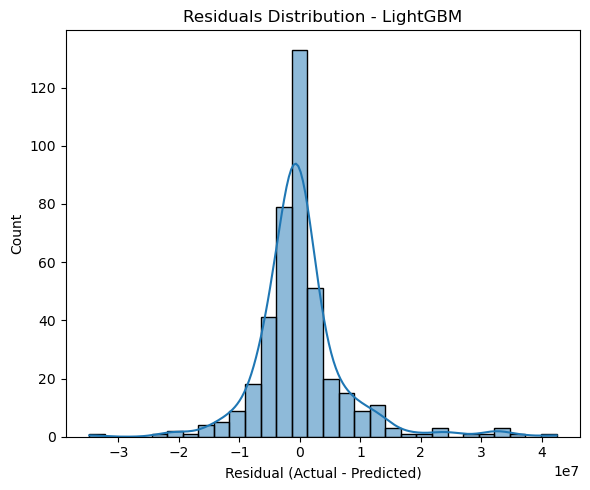

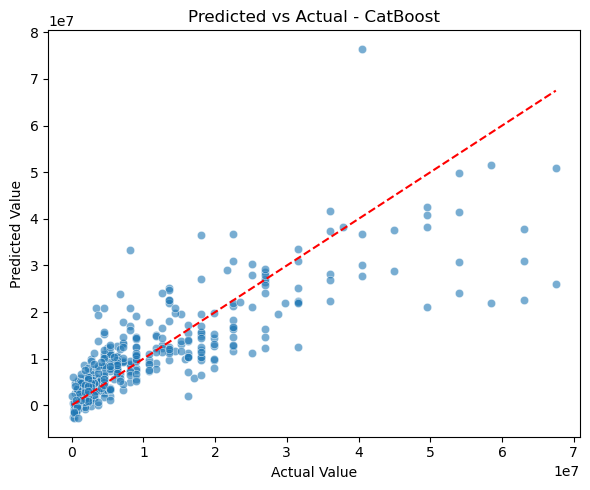

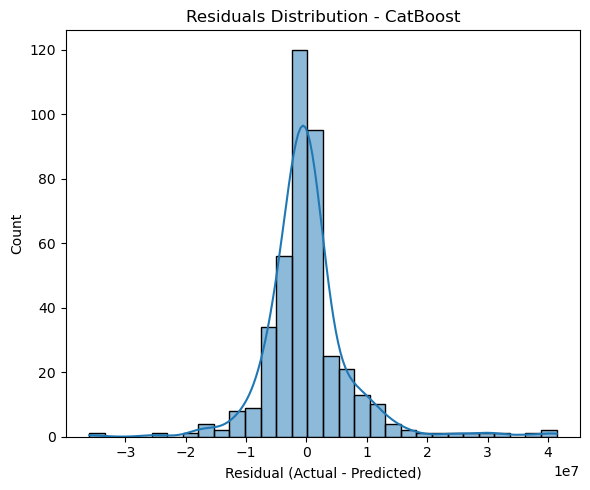

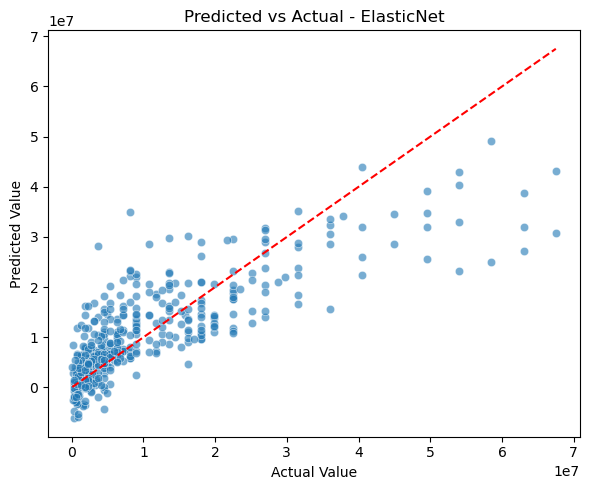

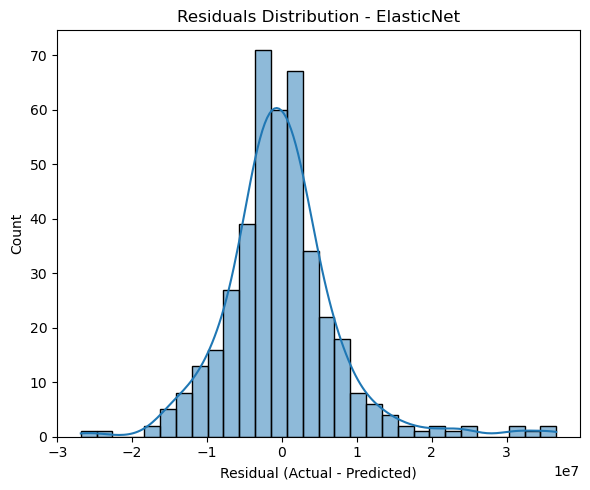

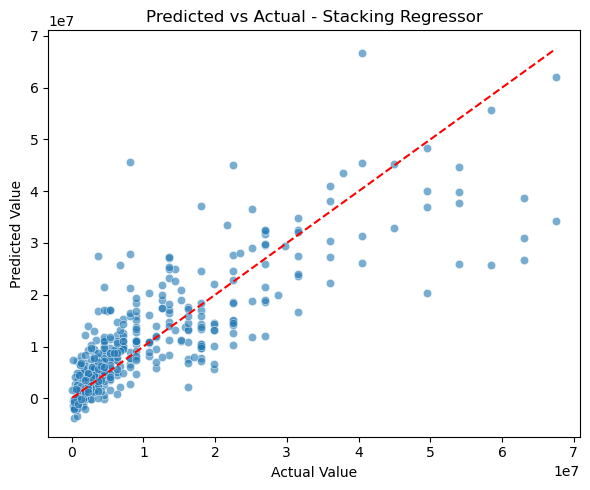

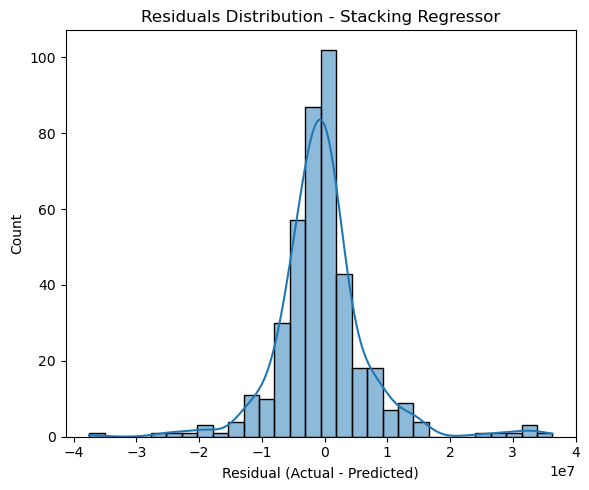

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv(r"C:\Users\b22fa\Desktop\football.csv")

# Drop ID column if present
if 'ID' in df.columns:
    df = df.drop(columns=['ID'])

# Separate features and target
X = df.drop(columns=['Value'])
y = df['Value']

# One-hot encode categorical columns
categorical_cols = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=categorical_cols)

# Clean column names
X.columns = X.columns.str.replace(r'[^\w\s]', '', regex=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X.columns)

# Scale data for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42, max_iter=10000),
}

# Store results for visualization
results = {}

# Train and evaluate models
for name, model in models.items():
    try:
        if name in ["Linear Regression", "ElasticNet"]:
            model.fit(X_train_scaled, y_train)
            preds = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            preds = model.predict(X_test)

        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        mse = mean_squared_error(y_test, preds)

        results[name] = {"R2": r2, "MAE": mae, "MSE": mse}

        print(f"\n=== {name} ===")
        print("R² Score:", r2)
        print("MAE:", mae)
        print("MSE:", mse)

    except Exception as e:
        print(f"\n=== {name} ===")
        print("⚠️ Error during training:", e)

# Stacking Regressor
try:
    stack = StackingRegressor(
        estimators=[
            ('xgb', models["XGBoost"]),
            ('rf', models["Random Forest"]),
            ('lr', LinearRegression())
        ],
        final_estimator=ElasticNet(max_iter=10000)
    )
    stack.fit(X_train, y_train)
    stack_preds = stack.predict(X_test)

    r2 = r2_score(y_test, stack_preds)
    mae = mean_absolute_error(y_test, stack_preds)
    mse = mean_squared_error(y_test, stack_preds)

    results["Stacking Regressor"] = {"R2": r2, "MAE": mae, "MSE": mse}

    print("\n=== Stacking Regressor ===")
    print("R² Score:", r2)
    print("MAE:", mae)
    print("MSE:", mse)
except Exception as e:
    print("\n=== Stacking Regressor ===")
    print("⚠️ Error during training:", e)

# Visualize results
results_df = pd.DataFrame(results).T
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(x=results_df.index, y="R2", data=results_df, ax=axes[0])
axes[0].set_title("R² Score Comparison")
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x=results_df.index, y="MAE", data=results_df, ax=axes[1])
axes[1].set_title("Mean Absolute Error (MAE)")
axes[1].tick_params(axis='x', rotation=45)

sns.barplot(x=results_df.index, y="MSE", data=results_df, ax=axes[2])
axes[2].set_title("Mean Squared Error (MSE)")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Feature importance for tree-based models
tree_models = ["Random Forest", "XGBoost", "LightGBM", "CatBoost"]
for name in tree_models:
    model = models[name]
    importances = model.feature_importances_
    importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importances})
    importance_df = importance_df.sort_values(by="Importance", ascending=False).head(15)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=importance_df)
    plt.title(f"Top 15 Feature Importances - {name}")
    plt.tight_layout()
    plt.show()
# Plot predicted vs actual values and residuals for each model
for name, model in models.items():
    try:
        if name in ["Linear Regression", "ElasticNet"]:
            y_pred = model.predict(X_test_scaled)
        else:
            y_pred = model.predict(X_test)

        # Plot predicted vs actual
        plt.figure(figsize=(6, 5))
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Actual Value")
        plt.ylabel("Predicted Value")
        plt.title(f"Predicted vs Actual - {name}")
        plt.tight_layout()
        plt.show()

        # Plot residuals
        residuals = y_test - y_pred
        plt.figure(figsize=(6, 5))
        sns.histplot(residuals, bins=30, kde=True)
        plt.title(f"Residuals Distribution - {name}")
        plt.xlabel("Residual (Actual - Predicted)")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"\n⚠️ Could not plot for {name}: {e}")

# Include stacking model in the same format
try:
    y_pred_stack = stack.predict(X_test)

    # Predicted vs Actual
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_test, y=y_pred_stack, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Value")
    plt.ylabel("Predicted Value")
    plt.title("Predicted vs Actual - Stacking Regressor")
    plt.tight_layout()
    plt.show()

    # Residuals
    residuals_stack = y_test - y_pred_stack
    plt.figure(figsize=(6, 5))
    sns.histplot(residuals_stack, bins=30, kde=True)
    plt.title("Residuals Distribution - Stacking Regressor")
    plt.xlabel("Residual (Actual - Predicted)")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("\n⚠️ Could not plot for Stacking Regressor:", e)
